# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [82]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
!nvidia-smi

Tue May 13 01:05:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   45C    P8             18W /  130W |    5357MiB /   6144MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [69]:
import torch

Select the device to use

In [70]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare the dataset and dataloaders

In [71]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

In [72]:
from torchvision.datasets import ImageFolder

train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


In [73]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# VAE

## Create model

In [ ]:
from gnn import ConditionalVariationalAutoencoder as cVAE
from gnn import cVAETrainer
import torch.optim as optim
import torch.nn as nn


IMG_CHANNELS = 3
latent_dim = 100

# model
cvae_model = cVAE(IMG_CHANNELS, num_classes, latent_dim=latent_dim).to(device)

# optimizers
cvae_optimizer = torch.optim.Adam(cvae_model.parameters(), lr=0.0001)
cvae_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=cvae_optimizer, gamma=0.99)


cvae_trainer = cVAETrainer(
    cvae_model=cvae_model,
    optimizer=cvae_optimizer,
    num_classes=num_classes,
    scheduler=cvae_scheduler,
    latent_dim=latent_dim,
    device=device
)

## Training

Epoch 1/20: 100%|██████████| 246/246 [00:18<00:00, 13.14it/s]


Epoch 1/20: Total Loss: 417.6001, Recon Loss: 381.3168, KLD Loss: 36.2834


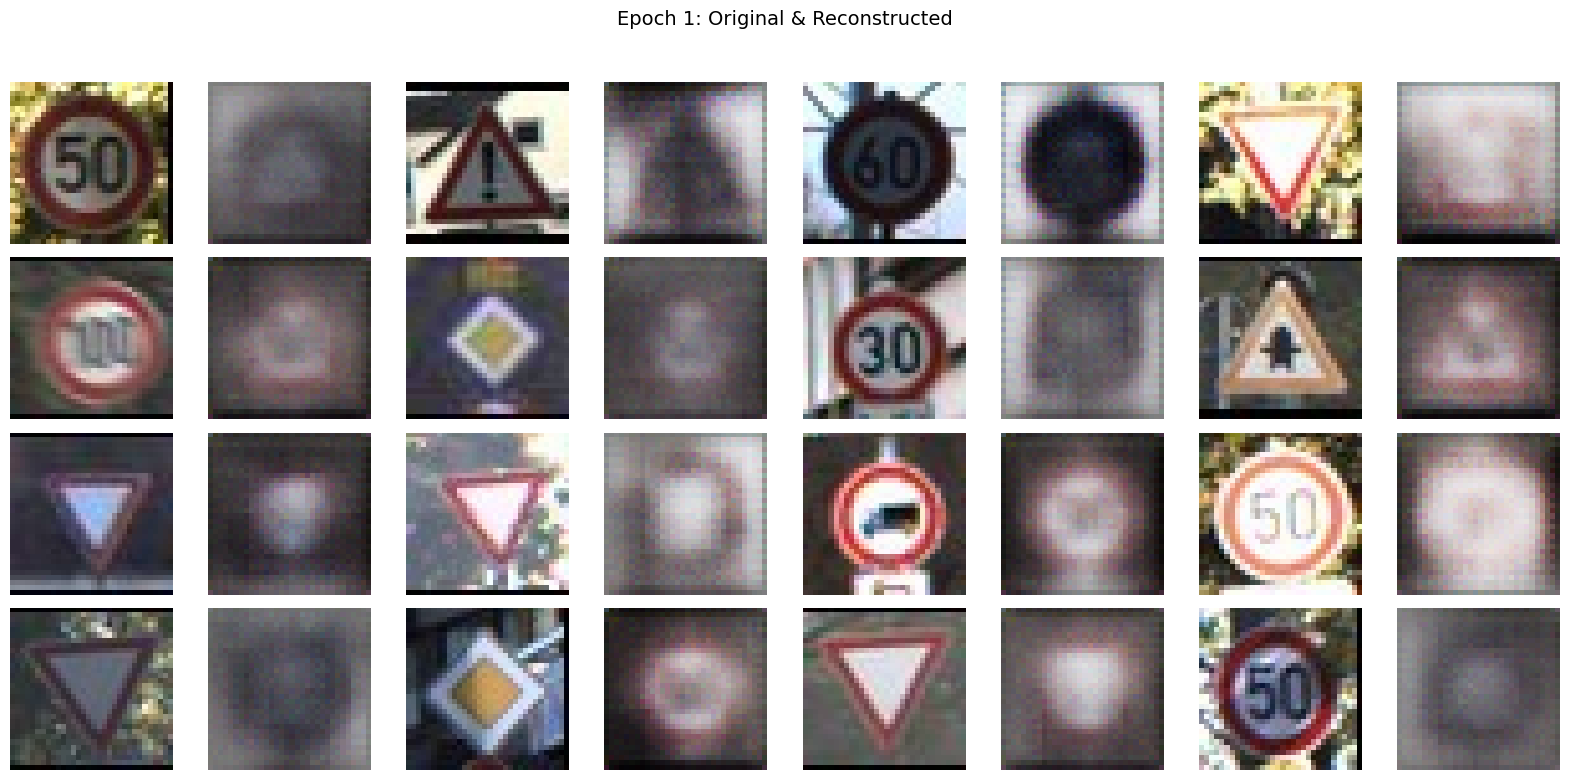

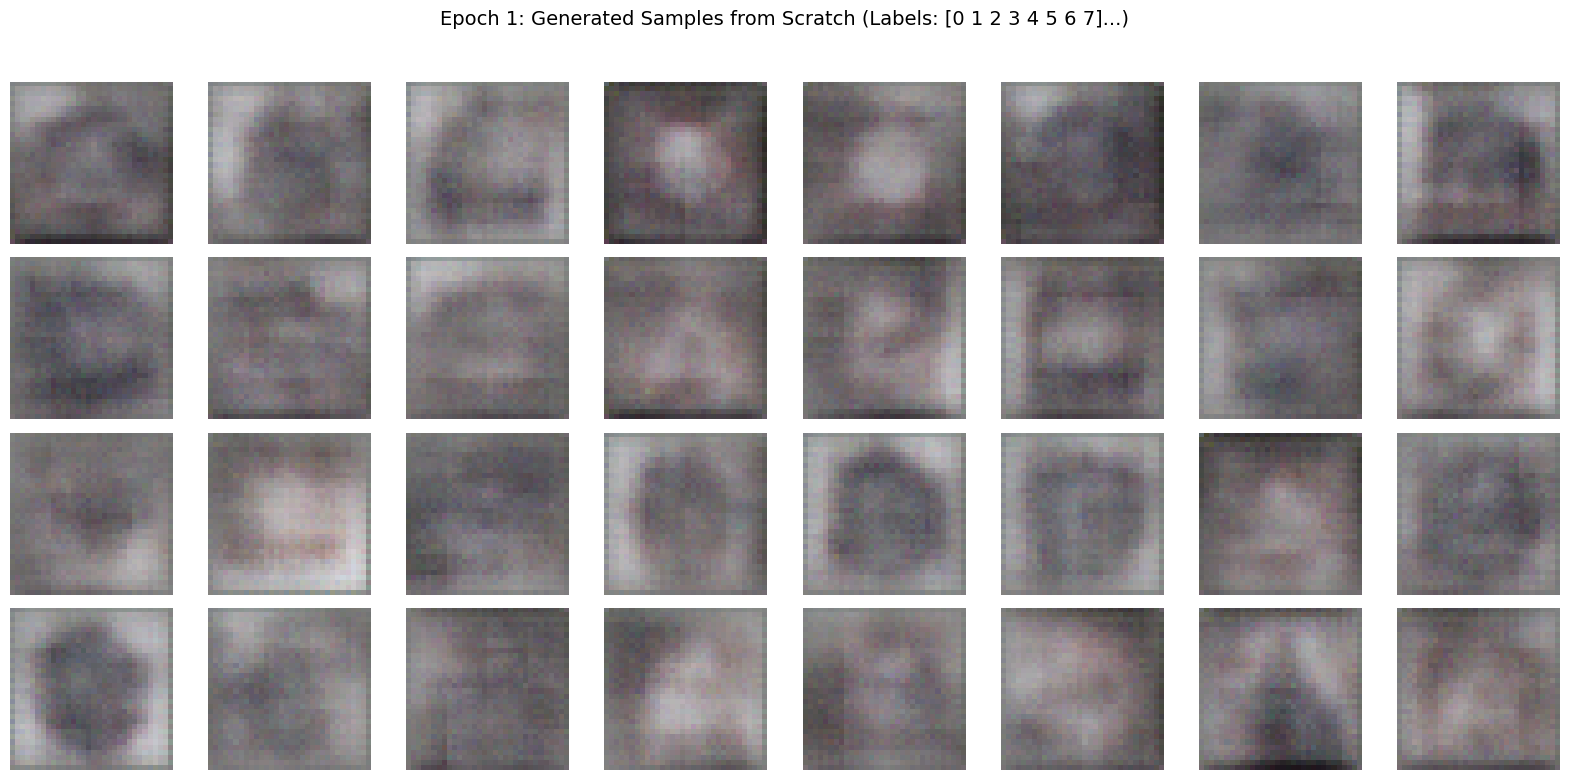

Epoch 2/20: 100%|██████████| 246/246 [00:22<00:00, 11.11it/s]


Epoch 2/20: Total Loss: 357.2577, Recon Loss: 315.3826, KLD Loss: 41.8751


Epoch 3/20: 100%|██████████| 246/246 [00:19<00:00, 12.69it/s]


Epoch 3/20: Total Loss: 310.6818, Recon Loss: 266.4464, KLD Loss: 44.2353


Epoch 4/20: 100%|██████████| 246/246 [00:22<00:00, 10.79it/s]


Epoch 4/20: Total Loss: 280.6285, Recon Loss: 235.6829, KLD Loss: 44.9455


Epoch 5/20: 100%|██████████| 246/246 [00:22<00:00, 11.03it/s]


Epoch 5/20: Total Loss: 262.3568, Recon Loss: 217.3830, KLD Loss: 44.9738


Epoch 6/20: 100%|██████████| 246/246 [00:18<00:00, 13.07it/s]


Epoch 6/20: Total Loss: 248.8111, Recon Loss: 203.5796, KLD Loss: 45.2315


Epoch 7/20: 100%|██████████| 246/246 [00:21<00:00, 11.28it/s]


Epoch 7/20: Total Loss: 237.8349, Recon Loss: 192.4519, KLD Loss: 45.3831


Epoch 8/20: 100%|██████████| 246/246 [00:19<00:00, 12.91it/s]


Epoch 8/20: Total Loss: 229.2125, Recon Loss: 183.6991, KLD Loss: 45.5134


Epoch 9/20: 100%|██████████| 246/246 [00:21<00:00, 11.43it/s]


Epoch 9/20: Total Loss: 222.0641, Recon Loss: 176.2364, KLD Loss: 45.8277


Epoch 10/20: 100%|██████████| 246/246 [00:21<00:00, 11.57it/s]


Epoch 10/20: Total Loss: 215.6616, Recon Loss: 169.6939, KLD Loss: 45.9676


Epoch 11/20: 100%|██████████| 246/246 [00:17<00:00, 13.95it/s]


Epoch 11/20: Total Loss: 210.2814, Recon Loss: 164.0684, KLD Loss: 46.2130


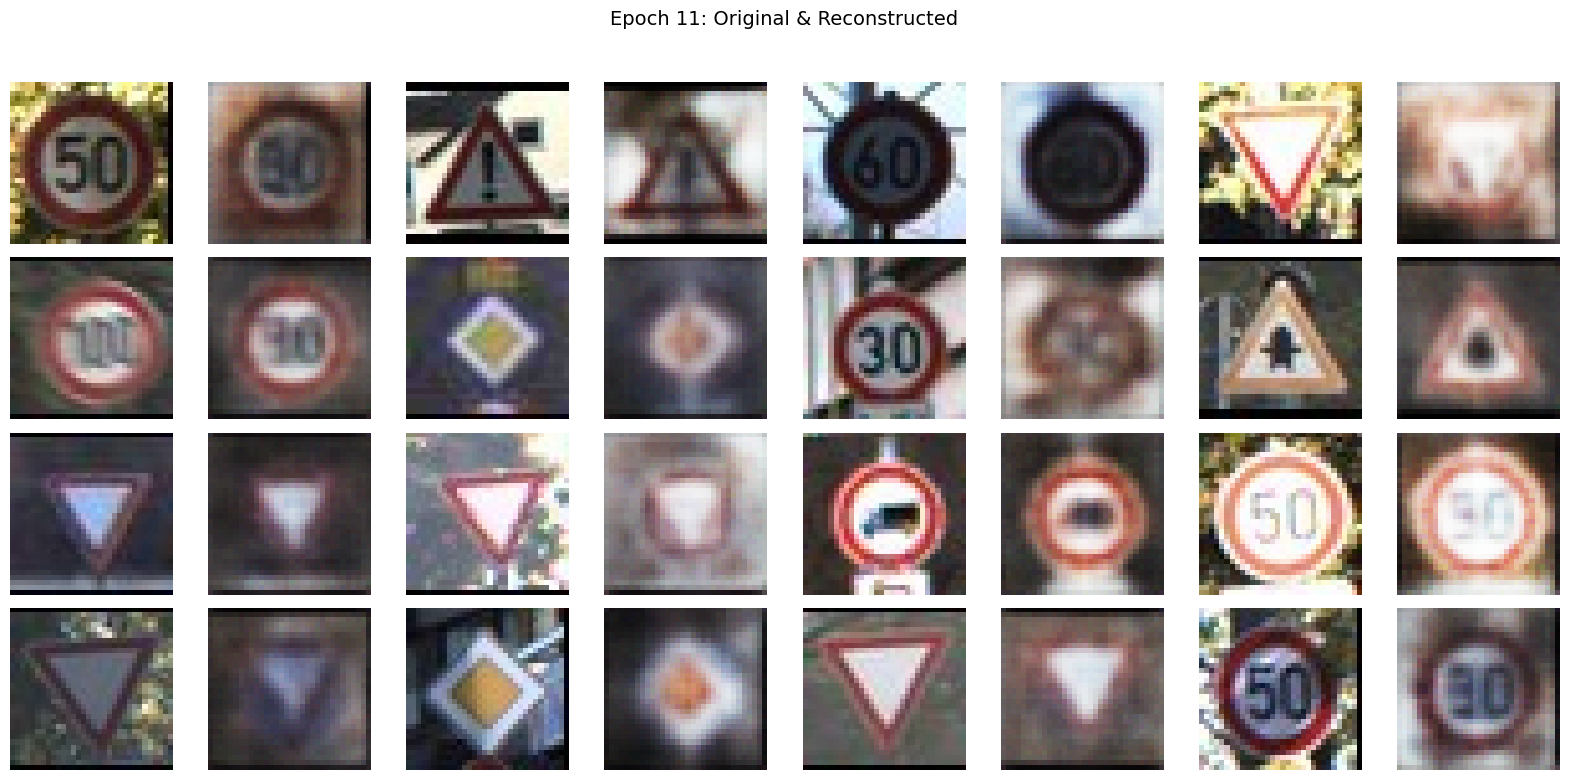

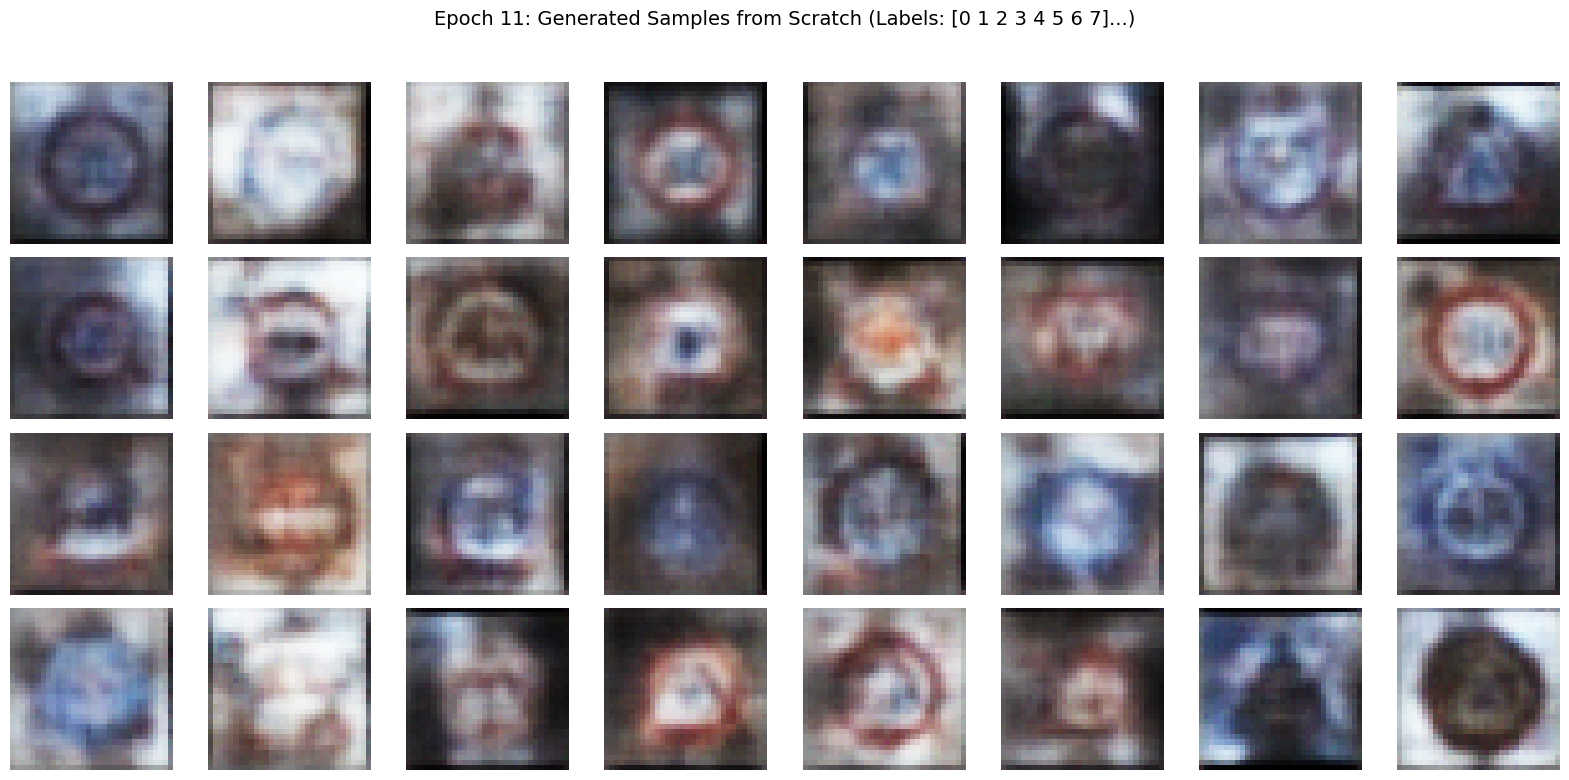

Epoch 12/20: 100%|██████████| 246/246 [00:21<00:00, 11.37it/s]


Epoch 12/20: Total Loss: 205.8948, Recon Loss: 159.4942, KLD Loss: 46.4006


Epoch 13/20: 100%|██████████| 246/246 [00:17<00:00, 14.27it/s]


Epoch 13/20: Total Loss: 201.8753, Recon Loss: 155.2437, KLD Loss: 46.6316


Epoch 14/20: 100%|██████████| 246/246 [00:21<00:00, 11.33it/s]


Epoch 14/20: Total Loss: 198.5800, Recon Loss: 151.6728, KLD Loss: 46.9073


Epoch 15/20: 100%|██████████| 246/246 [00:16<00:00, 14.50it/s]


Epoch 15/20: Total Loss: 195.2761, Recon Loss: 148.1422, KLD Loss: 47.1339


Epoch 16/20: 100%|██████████| 246/246 [00:22<00:00, 11.06it/s]


Epoch 16/20: Total Loss: 192.8070, Recon Loss: 145.4684, KLD Loss: 47.3386


Epoch 17/20: 100%|██████████| 246/246 [00:18<00:00, 13.59it/s]


Epoch 17/20: Total Loss: 190.0442, Recon Loss: 142.5807, KLD Loss: 47.4635


Epoch 18/20: 100%|██████████| 246/246 [00:22<00:00, 10.74it/s]


Epoch 18/20: Total Loss: 188.0953, Recon Loss: 140.3224, KLD Loss: 47.7729


Epoch 19/20: 100%|██████████| 246/246 [00:21<00:00, 11.53it/s]


Epoch 19/20: Total Loss: 185.8218, Recon Loss: 137.8488, KLD Loss: 47.9730


Epoch 20/20: 100%|██████████| 246/246 [00:17<00:00, 14.27it/s]


Epoch 20/20: Total Loss: 184.3146, Recon Loss: 136.1770, KLD Loss: 48.1376


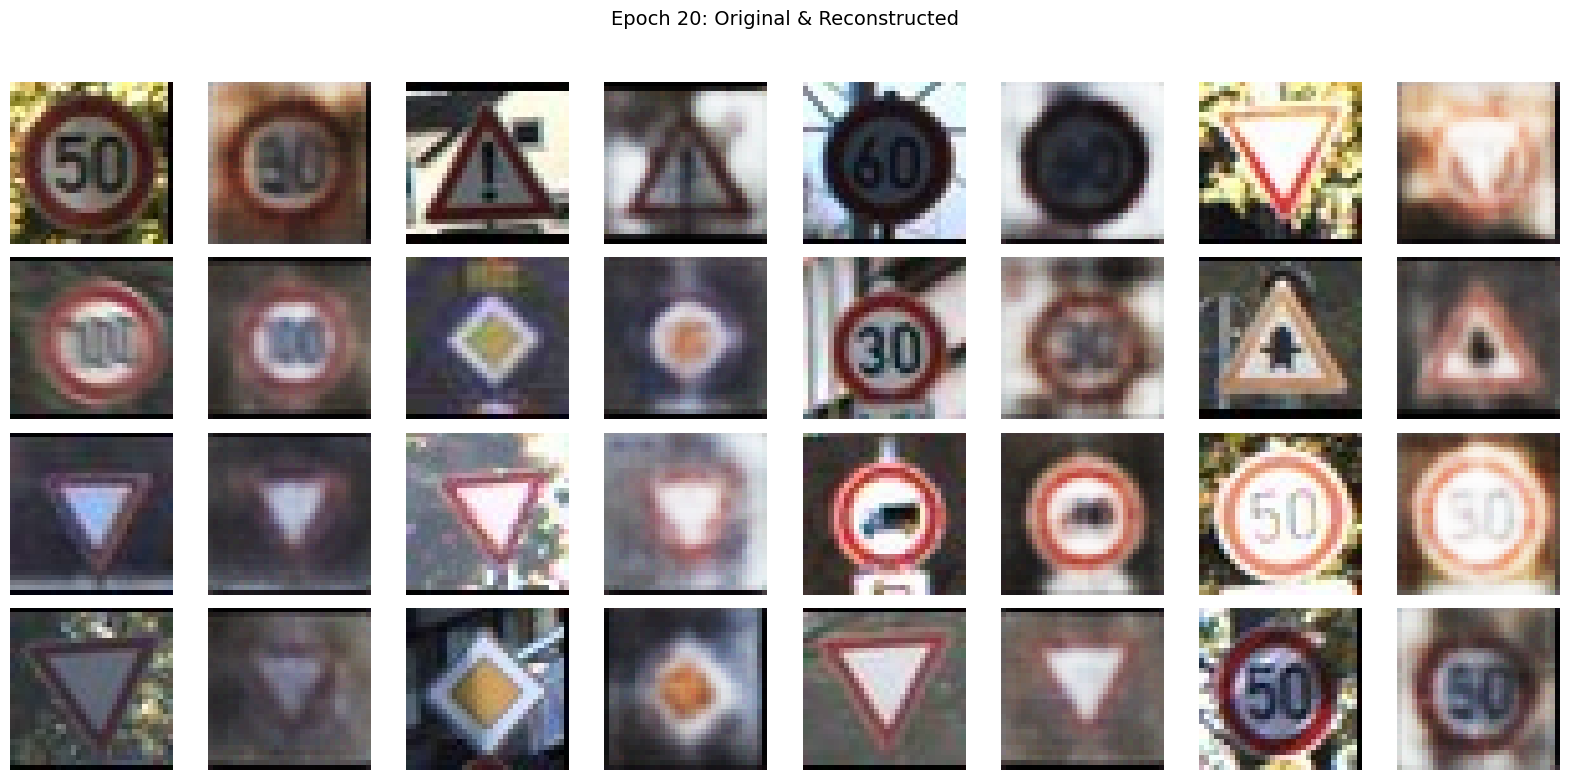

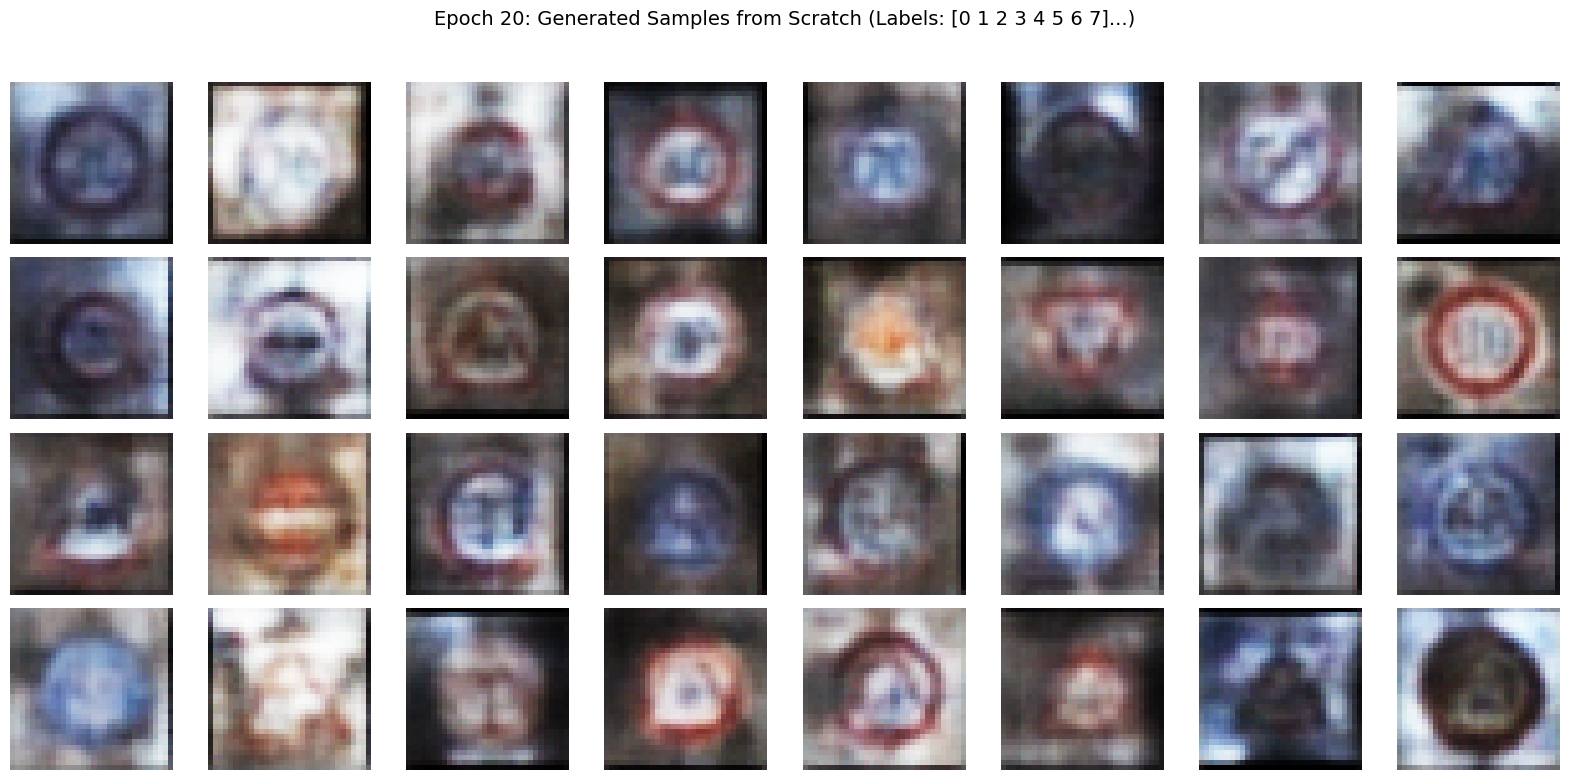

{'total_losses': [417.6001261269174,
  357.2577044479246,
  310.68178080737107,
  280.62848588896964,
  262.35675371371633,
  248.8110500428735,
  237.83493302508097,
  229.2124731792667,
  222.06406222707858,
  215.66158455949488,
  210.28141945939723,
  205.89483047113185,
  201.87534009731883,
  198.58004072235852,
  195.27612701664125,
  192.80695243773422,
  190.04417332594957,
  188.09528493493553,
  185.82179148604232,
  184.31462407305958],
 'reconstruction_losses': [381.3167647695154,
  315.382608305148,
  266.44644748098483,
  235.6829376840979,
  217.3829518139847,
  203.5795639162141,
  192.4518619940533,
  183.69907800938057,
  176.23637185445645,
  169.69394863717923,
  164.06837450973387,
  159.49424179201205,
  155.2437426559324,
  151.6727717950092,
  148.14220071808109,
  145.4683811528896,
  142.5807167301333,
  140.32242667965772,
  137.8487890600189,
  136.17704081341503],
 'kld_losses': [36.28336206296595,
  41.8750966234905,
  44.23533247350677,
  44.945548468488

In [ ]:
cvae_trainer.fit(train_dl, num_epochs=100)

## Save model

In [ ]:
import os
import torch

weights_dir = "./gnn/weights"

os.makedirs(weights_dir, exist_ok=True)

cvae_model_path = os.path.join(weights_dir, "cvae_model.pth")

torch.save(cvae_model.state_dict(), cvae_model_path)

print(f"cVAE model weights saved to: {cvae_model_path}")

# Evaluation

## Load Dataset

In [61]:
test_dir = "./data/test"
test_ds = ImageFolder(test_dir)
len(test_ds), len(test_ds.classes)

(7842, 43)

In [99]:
import os
import time
from torchvision.utils import save_image
from collections import Counter


results_id = time.time()
results_dir = f"./cvae_results/{results_id}"
os.makedirs(results_dir, exist_ok=True)

mean_t = torch.tensor(train_mean).view(1, IMG_CHANNELS, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, IMG_CHANNELS, 1, 1).to(device)
class_counts = Counter(test_ds.targets)

vae_model.eval()



for cls, cnt in class_counts.items():
    for i in range(cnt):
        z = torch.randn(1, latent_dim, device=device)
        label_tensor = torch.tensor([cls], dtype=torch.long, device=device)

        with torch.no_grad():
            img = cvae_model.generate(z, label_tensor)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"class_{cls}_sample_{i}.jpg")
        save_image(img.clamp(0, 1), fname)
print(f"Saved generated images to {fname}")

KeyboardInterrupt: 

Calculate the FID between test set and generated images

In [96]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")

100%|██████████| 62/62 [00:26<00:00,  2.31it/s]


FID: 159.06156257221988


In [98]:
# clean up


import shutil
import os

results_dir = f"./cvae_results/{results_id}"

# Check if the directory exists before trying to remove it
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
    print(f"Directory {results_dir}_{results_id} have been removed.")
else:
    print(f"The directory {results_dir}_{results_id} does not exist.")

Directory ./cvae_results/1747092739.8218522_1747092739.8218522 have been removed.
